In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
train_val = pd.read_csv('train_val.csv',low_memory=False)
train_tra = pd.read_csv('train_tra.csv',low_memory=False)
test = pd.read_csv('test_done.csv', low_memory=False)

In [47]:
# 拆分特征和标签
train_tra_x = train_tra.drop(['Sales'], axis=1)
train_tra_y = train_tra['Sales']

train_val_x = train_val.drop(['Sales'], axis=1)
train_val_y = train_val['Sales']


In [48]:
import rossmann as ross

In [49]:
ross.rossmann_test()

rossmann package


### 構建XGBOOST

In [50]:
import xgboost as xgb
from time import time

In [51]:
dtrain = xgb.DMatrix(train_tra_x, train_tra_y)

In [52]:
dvalid = xgb.DMatrix(train_val_x, train_val_y)

In [53]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

In [33]:
%%time

bst_cv1 = xgb.cv(params1, dtrain, num_boost_round, nfold=3,
                feval=rmspe_xg, maximize=False,early_stopping_rounds=100, verbose_eval=True)

[0]	train-rmse:7.43811+0.00059302	train-rmspe:0.999521+0	test-rmse:7.43812+0.001251	test-rmspe:0.999521+4.71405e-07
[1]	train-rmse:6.69644+0.000461103	train-rmspe:0.998808+1.41421e-06	test-rmse:6.69646+0.00139712	test-rmspe:0.998808+8.16497e-07
[2]	train-rmse:6.02909+0.00053173	train-rmspe:0.997518+1.24722e-06	test-rmse:6.02909+0.00130242	test-rmspe:0.997518+4.54606e-06
[3]	train-rmse:5.42877+0.000534328	train-rmspe:0.995342+6.2361e-06	test-rmse:5.42877+0.0012936	test-rmspe:0.995342+1.15181e-05
[4]	train-rmse:4.88831+0.000437988	train-rmspe:0.991912+1.26579e-05	test-rmse:4.8883+0.00137179	test-rmspe:0.991911+1.98158e-05
[5]	train-rmse:4.40228+0.000382665	train-rmspe:0.986767+1.91543e-05	test-rmse:4.40229+0.00147186	test-rmspe:0.986766+2.80832e-05
[6]	train-rmse:3.96512+0.000524809	train-rmspe:0.979444+3.30387e-05	test-rmse:3.96512+0.00126276	test-rmspe:0.979442+5.89406e-05
[7]	train-rmse:3.57173+0.000713886	train-rmspe:0.969529+6.07124e-05	test-rmse:3.57169+0.00107966	test-rmspe:0.9695

[65]	train-rmse:0.197076+0.00164786	train-rmspe:0.231579+0.0100841	test-rmse:0.200049+0.00147319	test-rmspe:0.24083+0.0238427
[66]	train-rmse:0.195682+0.00190935	train-rmspe:0.230392+0.0102449	test-rmse:0.198706+0.00170342	test-rmspe:0.239579+0.0240102
[67]	train-rmse:0.194259+0.00191268	train-rmspe:0.229171+0.0103624	test-rmse:0.197329+0.00164129	test-rmspe:0.238649+0.0243128
[68]	train-rmse:0.193342+0.00197263	train-rmspe:0.228374+0.0103441	test-rmse:0.196496+0.00170448	test-rmspe:0.238027+0.0242984
[69]	train-rmse:0.192401+0.0020658	train-rmspe:0.226672+0.00950618	test-rmse:0.195589+0.0017607	test-rmspe:0.237031+0.0241139
[70]	train-rmse:0.19153+0.00243634	train-rmspe:0.22586+0.00959816	test-rmse:0.194745+0.00218774	test-rmspe:0.236451+0.0244921
[71]	train-rmse:0.190844+0.00232432	train-rmspe:0.225316+0.00972673	test-rmse:0.194089+0.00202429	test-rmspe:0.235918+0.0244039
[72]	train-rmse:0.189437+0.002071	train-rmspe:0.224067+0.00943443	test-rmse:0.192709+0.0019046	test-rmspe:0.23459

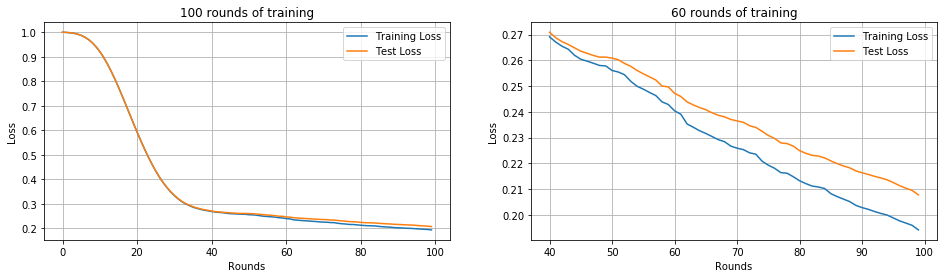

In [36]:
fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_size_inches(16,4)

ax1.set_title('100 rounds of training')
ax1.set_xlabel('Rounds')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.plot(bst_cv1[['train-rmspe-mean','test-rmspe-mean']])
ax1.legend(['Training Loss','Test Loss'])

ax2.set_title('60 rounds of training')
ax2.set_xlabel('Rounds')
ax2.set_ylabel('Loss')
ax2.grid(True)
ax2.plot(bst_cv1[40:][['train-rmspe-mean','test-rmspe-mean']])
ax2.legend(['Training Loss','Test Loss'])

In [43]:
xgb_bst1 = xgb.train(params=params1, dtrain=dtrain, num_boost_round=100,
                             feval=rmspe_xg, maximize=False)

In [45]:
#采用保留数据集进行检测
print("validating")
yhat = xgb_bst1.predict(xgb.DMatrix(train_tra_x))
error = rmspe(np.expm1(train_tra_y), np.expm1(yhat))

print('RMSPE: {:.6f}'.format(error))

validating
RMSPE: 0.195332


#### 说明num_boost_round设置为100太小，但是也不需要设置的太大 ，后期发生了比较严重的过拟合问题。

### XGBoost 參數調節

In [58]:
class XGBoostRegressor(object):
    def __init__(self, **kwargs):
        self.params = kwargs
        if 'num_boost_round' in self.params:
            self.num_boost_round = self.params['num_boost_round']
        self.params.update({'silent': 1, 'objective': 'reg:linear', 'seed': 0})

    def fit(self, x_train, y_train):
        dtrain = xgb.DMatrix(x_train, y_train)
        self.bst = xgb.train(params=self.params, dtrain=dtrain, num_boost_round=self.num_boost_round,
                             feval=rmspe_xg, maximize=False)

    def predict(self, x_pred):
        dpred = xgb.DMatrix(x_pred)
        return self.bst.predict(dpred)

    def kfold(self, x_train, y_train, nfold=5):
        dtrain = xgb.DMatrix(x_train, y_train)
        cv_rounds = xgb.cv(params=self.params, dtrain=dtrain, num_boost_round=self.num_boost_round,
                           nfold=nfold, feval=rmspe_xg, maximize=False, early_stopping_rounds=10)
        return cv_rounds.iloc[-1,:]

    def plot_feature_importances(self):
        feat_imp = pd.Series(self.bst.get_fscore()).sort_values(ascending=False)
        feat_imp.plot(title='Feature Importances')
        plt.ylabel('Feature Importance Score')

    def get_params(self, deep=True):
        return self.params

    def set_params(self, **params):
        self.params.update(params)
        return self
    

In [66]:
from sklearn.model_selection import ShuffleSplit

####  1. 修改max_depth和min_child_weight

In [67]:
xgb_param_grid = {'max_depth': list(range(8,12)), 'min_child_weight': list((1,3,6))}
xgb_param_grid['max_depth']

[8, 9, 10, 11]

In [68]:
params3 = {"objective": "reg:linear",
          "booster" : "gbtree",
          "seed": 0,
          "silent": 1,
          }
num_boost_round = 400

In [69]:
from sklearn.model_selection import GridSearchCV

In [70]:
%%time
#网格搜索 
grid = GridSearchCV(XGBoostRegressor( num_boost_round=500),
                param_grid=xgb_param_grid, cv=ShuffleSplit(test_size=0.20, n_splits =1, random_state=0), scoring=rmspe_score)

Wall time: 0 ns


In [71]:
train_tra_x.shape

(700535, 27)

In [72]:
%%time
grid.fit(train_tra_x, train_tra_y)

Wall time: 43min 8s


GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=0, test_size=0.2, train_size=None),
             error_score='raise-deprecating',
             estimator=<__main__.XGBoostRegressor object at 0x0000020D81A995F8>,
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [8, 9, 10, 11],
                         'min_child_weight': [1, 3, 6]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(rmspe, greater_is_better=False), verbose=0)

In [73]:
grid.best_params_

{'max_depth': 10, 'min_child_weight': 6}

In [74]:
grid.cv_results_['params']

[{'max_depth': 8, 'min_child_weight': 1},
 {'max_depth': 8, 'min_child_weight': 3},
 {'max_depth': 8, 'min_child_weight': 6},
 {'max_depth': 9, 'min_child_weight': 1},
 {'max_depth': 9, 'min_child_weight': 3},
 {'max_depth': 9, 'min_child_weight': 6},
 {'max_depth': 10, 'min_child_weight': 1},
 {'max_depth': 10, 'min_child_weight': 3},
 {'max_depth': 10, 'min_child_weight': 6},
 {'max_depth': 11, 'min_child_weight': 1},
 {'max_depth': 11, 'min_child_weight': 3},
 {'max_depth': 11, 'min_child_weight': 6}]

In [75]:
grid.cv_results_['mean_test_score']

array([-0.12496345, -0.12479607, -0.12564314, -0.12498943, -0.12440787,
       -0.1236658 , -0.12474744, -0.12465804, -0.12350449, -0.12702132,
       -0.12587213, -0.12608268])

In [130]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)
    _.set_size_inches(16,6)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

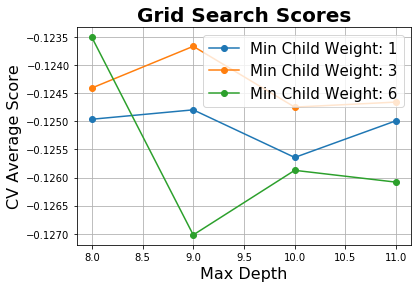

In [76]:
# Calling Method 
plot_grid_search(grid.cv_results_, xgb_param_grid['max_depth'], xgb_param_grid['min_child_weight'], 'Max Depth', 'Min Child Weight')

#### 选取出最佳的参数是MIN_CHILD_WEIGHT=3, MAX_DEPTH=9

### 调节GAMMA值

In [120]:
%%time

xgb_param_grid = {'gamma':[ 0.1 * i for i in range(0,5)]}
#网格搜索 

Wall time: 0 ns


In [121]:
grid2 = GridSearchCV(XGBoostRegressor( num_boost_round=500, max_depth=10, min_child_weight=6),
                param_grid=xgb_param_grid, cv=ShuffleSplit(test_size=0.20, n_splits =1, random_state=0), scoring=rmspe_score)

In [84]:
%%time
grid2.fit(train_tra_x, train_tra_y)

D:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Wall time: 20min 18s


GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=0, test_size=0.2, train_size=None),
             error_score='raise-deprecating',
             estimator=<__main__.XGBoostRegressor object at 0x0000020D8EF71128>,
             iid='warn', n_jobs=None,
             param_grid={'gamma': [0.0, 0.1, 0.2, 0.30000000000000004, 0.4]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(rmspe, greater_is_better=False), verbose=0)

In [85]:
grid2.best_params_

{'gamma': 0.0}

In [88]:
grid2.cv_results_

{'mean_fit_time': array([219.24154902, 189.24259782, 201.67000985, 194.78148127,
        197.37676597]),
 'std_fit_time': array([0., 0., 0., 0., 0.]),
 'mean_score_time': array([4.45981622, 1.0487113 , 0.82792807, 0.76544309, 0.81766748]),
 'std_score_time': array([0., 0., 0., 0., 0.]),
 'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.30000000000000004, 0.4],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'gamma': 0.0},
  {'gamma': 0.1},
  {'gamma': 0.2},
  {'gamma': 0.30000000000000004},
  {'gamma': 0.4}],
 'split0_test_score': array([-0.12350449, -0.13126807, -0.13252887, -0.13728874, -0.13669961]),
 'mean_test_score': array([-0.12350449, -0.13126807, -0.13252887, -0.13728874, -0.13669961]),
 'std_test_score': array([0., 0., 0., 0., 0.]),
 'rank_test_score': array([1, 2, 3, 5, 4])}

In [124]:
def plot_grid_search_one(cv_results, grid_param_1,  name_param_1):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    ax.plot(grid_param_1, scores_mean, '-o')

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')


In [118]:
plot_grid_search_one(grid2.cv_results_, xgb_param_grid['gamma'], 'Gamma')

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

###  调节样本采样方式 subsample 和 colsample_bytree

In [89]:
from sklearn.model_selection import ShuffleSplit

In [ ]:
xgb_param_grid3 = {'subsample':[ 0.1 * i for i in range(6,9)],
                      'colsample_bytree':[ 0.1 * i for i in range(6,9)]}
                      
# xgb_param_grid3 = {'subsample':[ 0.1 * i for i in range(6,7)],}

In [90]:
grid3 = GridSearchCV(XGBoostRegressor( num_boost_round=500, max_depth=10, min_child_weight=6, gamma=0.0),
                                      param_grid=xgb_param_grid3, cv=ShuffleSplit(test_size=0.20, n_splits =1, random_state=0), scoring=rmspe_score)

In [91]:
%%time
grid3.fit(train_tra_x, train_tra_y)

D:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Wall time: 31min 50s


GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=0, test_size=0.2, train_size=None),
             error_score='raise-deprecating',
             estimator=<__main__.XGBoostRegressor object at 0x0000020D8FD036D8>,
             iid='warn', n_jobs=None,
             param_grid={'colsample_bytree': [0.6000000000000001,
                                              0.7000000000000001, 0.8],
                         'subsample': [0.6000000000000001, 0.7000000000000001,
                                       0.8]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(rmspe, greater_is_better=False), verbose=0)

In [101]:
grid3.cv_results_

{'mean_fit_time': array([177.30621219, 167.18331552, 159.61232972, 189.14898324,
        181.18626022, 171.57964897, 209.60489726, 201.0508585 ,
        198.42103124]),
 'std_fit_time': array([0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'mean_score_time': array([3.40775228, 3.52049112, 3.34536695, 3.34296227, 3.38982558,
        3.40544629, 3.37560225, 3.37420511, 3.88682461]),
 'std_score_time': array([0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'param_colsample_bytree': masked_array(data=[0.6000000000000001, 0.6000000000000001,
                    0.6000000000000001, 0.7000000000000001,
                    0.7000000000000001, 0.7000000000000001, 0.8, 0.8, 0.8],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_subsample': masked_array(data=[0.6000000000000001, 0.7000000000000001, 0.8,
                    0.6000000000000001, 0.7000000000000001, 0.8,
                    0.60000000000

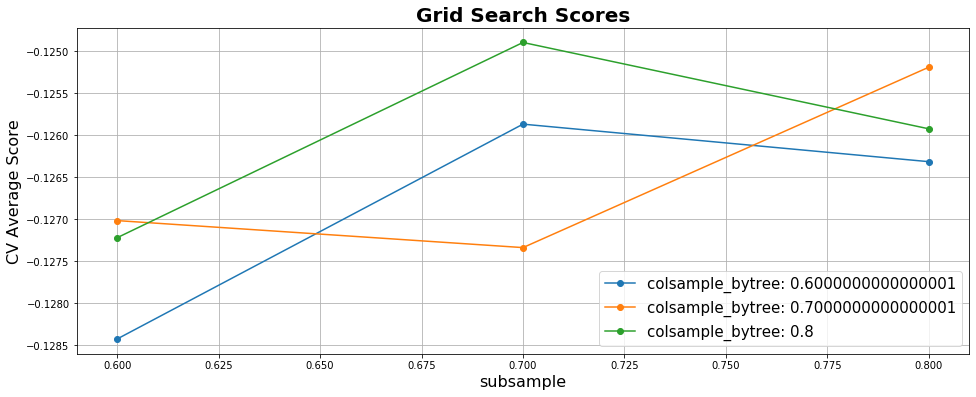

In [131]:
plot_grid_search(grid3.cv_results_, xgb_param_grid3['subsample'],xgb_param_grid3['colsample_bytree'] ,'subsample','colsample_bytree')

### 减小学习率并增大树个数

In [122]:
%%time

xgb_param_grid = {'eta':[0.5,0.4,0.3,0.2,0.1,0.075,0.05,0.04,0.03]}

Wall time: 0 ns


In [98]:
grid4 = GridSearchCV(XGBoostRegressor(num_boost_round=500, gamma=0, max_depth=10, min_child_weight=6,colsample_bytree=0.8, subsample=0.7),
                    param_grid=xgb_param_grid, cv=5, scoring=rmspe_score)

Wall time: 0 ns


In [99]:
%%time
grid4.fit(train_tra_x, train_tra_y)

D:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Wall time: 2h 17min 15s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=<__main__.XGBoostRegressor object at 0x0000020D8FD03CC0>,
             iid='warn', n_jobs=None,
             param_grid={'eta': [0.5, 0.4, 0.3, 0.2, 0.1, 0.075, 0.05, 0.04,
                                 0.03]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(rmspe, greater_is_better=False), verbose=0)

In [100]:
grid4.best_params_

{'eta': 0.04}

In [102]:
grid4.cv_results_

{'mean_fit_time': array([167.89401226, 168.76144242, 167.83579483, 167.35887136,
        164.18374701, 163.42451239, 163.96570282, 199.31423812,
        217.8762836 ]),
 'std_fit_time': array([ 0.30363533,  1.8823429 ,  0.76545981,  0.93170775,  0.51738659,
         0.63123028,  1.6447776 , 50.21462707, 62.81280606]),
 'mean_score_time': array([2.99984603, 2.93374591, 2.9801712 , 2.81746826, 2.72436371,
        2.56954226, 2.50240149, 2.83985763, 2.92885056]),
 'std_score_time': array([0.16860192, 0.15145271, 0.16658992, 0.11962805, 0.11688835,
        0.10107402, 0.1021562 , 0.46238579, 0.30920516]),
 'param_eta': masked_array(data=[0.5, 0.4, 0.3, 0.2, 0.1, 0.075, 0.05, 0.04, 0.03],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'params': [{'eta': 0.5},
  {'eta': 0.4},
  {'eta': 0.3},
  {'eta': 0.2},
  {'eta': 0.1},
  {'eta': 0.075},
  {'eta': 0.05},
  {'eta': 0.04},
  {'eta':

No handles with labels found to put in legend.


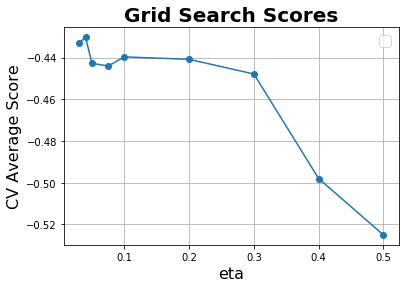

In [125]:
plot_grid_search_one(grid4.cv_results_,xgb_param_grid['eta'],'eta')

In [132]:
params5 = {"objective": "reg:linear",
          "booster" : "gbtree",
          "seed": 0,
          "eta": 0.04,
          "max_depth": 10,
          "subsample": 0.8,
          "colsample_bytree": 0.7,
          "silent": 1,
          "min_child_weight": 6,
          "gamma" : 0.0,
          }

In [133]:
gmb = xgb.train(params=params5, dtrain=dtrain, num_boost_round=1000,
                             feval=rmspe_xg,evals=watchlist, early_stopping_rounds=100 )

[0]	train-rmse:7.93227	eval-rmse:7.96935	train-rmspe:5802.22	eval-rmspe:6021.88
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:7.61567	eval-rmse:7.65218	train-rmspe:3476.86	eval-rmspe:3607.18
[2]	train-rmse:7.31171	eval-rmse:7.34726	train-rmspe:2274.53	eval-rmspe:2357.33
[3]	train-rmse:7.01989	eval-rmse:7.05461	train-rmspe:1569.18	eval-rmspe:1624.84
[4]	train-rmse:6.73982	eval-rmse:6.77344	train-rmspe:1123.89	eval-rmspe:1162.44
[5]	train-rmse:6.47096	eval-rmse:6.50353	train-rmspe:825.837	eval-rmspe:853.245
[6]	train-rmse:6.21291	eval-rmse:6.24475	train-rmspe:620.033	eval-rmspe:639.959
[7]	train-rmse:5.96524	eval-rmse:5.99615	train-rmspe:473.776	eval-rmspe:488.436
[8]	train-rmse:5.72743	eval-rmse:5.75715	train-rmspe:366.98	eval-rmspe:377.911
[9]	train-rmse:5.49913	eval-rmse:5.52801	train-rmspe:287.977	eval-rmspe:296.312
[10]	train-rmse:5.28	eval-rmse:5.30832	train-rmspe:228.

[98]	train-rmse:0.278056	eval-rmse:0.285009	train-rmspe:0.340937	eval-rmspe:0.353678
[99]	train-rmse:0.274209	eval-rmse:0.281205	train-rmspe:0.334598	eval-rmspe:0.347205
[100]	train-rmse:0.270921	eval-rmse:0.278009	train-rmspe:0.32901	eval-rmspe:0.341593
[101]	train-rmse:0.267943	eval-rmse:0.275083	train-rmspe:0.323924	eval-rmspe:0.336368
[102]	train-rmse:0.264851	eval-rmse:0.272188	train-rmspe:0.318703	eval-rmspe:0.33131
[103]	train-rmse:0.262146	eval-rmse:0.269688	train-rmspe:0.314051	eval-rmspe:0.326867
[104]	train-rmse:0.259071	eval-rmse:0.266944	train-rmspe:0.308964	eval-rmspe:0.32208
[105]	train-rmse:0.256839	eval-rmse:0.264775	train-rmspe:0.305042	eval-rmspe:0.318072
[106]	train-rmse:0.254514	eval-rmse:0.262628	train-rmspe:0.300883	eval-rmspe:0.314043
[107]	train-rmse:0.252411	eval-rmse:0.26073	train-rmspe:0.297168	eval-rmspe:0.31053
[108]	train-rmse:0.250214	eval-rmse:0.258707	train-rmspe:0.293367	eval-rmspe:0.306846
[109]	train-rmse:0.247935	eval-rmse:0.256467	train-rmspe:0.28

[194]	train-rmse:0.173065	eval-rmse:0.188906	train-rmspe:0.176683	eval-rmspe:0.196192
[195]	train-rmse:0.17239	eval-rmse:0.188276	train-rmspe:0.175895	eval-rmspe:0.195536
[196]	train-rmse:0.172178	eval-rmse:0.188186	train-rmspe:0.175636	eval-rmspe:0.195356
[197]	train-rmse:0.171468	eval-rmse:0.187549	train-rmspe:0.174876	eval-rmspe:0.194677
[198]	train-rmse:0.170983	eval-rmse:0.187181	train-rmspe:0.174328	eval-rmspe:0.194285
[199]	train-rmse:0.170798	eval-rmse:0.187101	train-rmspe:0.174107	eval-rmspe:0.19411
[200]	train-rmse:0.170649	eval-rmse:0.187037	train-rmspe:0.173925	eval-rmspe:0.194001
[201]	train-rmse:0.169633	eval-rmse:0.186132	train-rmspe:0.17268	eval-rmspe:0.193012
[202]	train-rmse:0.169096	eval-rmse:0.185573	train-rmspe:0.1721	eval-rmspe:0.192424
[203]	train-rmse:0.168983	eval-rmse:0.185472	train-rmspe:0.171966	eval-rmspe:0.192298
[204]	train-rmse:0.168402	eval-rmse:0.184966	train-rmspe:0.17134	eval-rmspe:0.191783
[205]	train-rmse:0.168275	eval-rmse:0.184874	train-rmspe:0.1

[290]	train-rmse:0.140207	eval-rmse:0.161484	train-rmspe:0.140911	eval-rmspe:0.167291
[291]	train-rmse:0.140052	eval-rmse:0.161408	train-rmspe:0.140746	eval-rmspe:0.167221
[292]	train-rmse:0.139864	eval-rmse:0.161252	train-rmspe:0.140546	eval-rmspe:0.167062
[293]	train-rmse:0.139751	eval-rmse:0.161155	train-rmspe:0.140436	eval-rmspe:0.166962
[294]	train-rmse:0.139415	eval-rmse:0.160905	train-rmspe:0.140085	eval-rmspe:0.166711
[295]	train-rmse:0.139285	eval-rmse:0.160933	train-rmspe:0.139949	eval-rmspe:0.166671
[296]	train-rmse:0.139203	eval-rmse:0.160871	train-rmspe:0.139862	eval-rmspe:0.166607
[297]	train-rmse:0.138908	eval-rmse:0.160655	train-rmspe:0.13955	eval-rmspe:0.166385
[298]	train-rmse:0.138588	eval-rmse:0.160362	train-rmspe:0.139239	eval-rmspe:0.166122
[299]	train-rmse:0.138223	eval-rmse:0.160032	train-rmspe:0.13888	eval-rmspe:0.165817
[300]	train-rmse:0.137773	eval-rmse:0.159695	train-rmspe:0.13841	eval-rmspe:0.165485
[301]	train-rmse:0.137407	eval-rmse:0.159434	train-rmspe:

[386]	train-rmse:0.119797	eval-rmse:0.145819	train-rmspe:0.119923	eval-rmspe:0.15233
[387]	train-rmse:0.119606	eval-rmse:0.145656	train-rmspe:0.11972	eval-rmspe:0.152181
[388]	train-rmse:0.119546	eval-rmse:0.145608	train-rmspe:0.119661	eval-rmspe:0.152146
[389]	train-rmse:0.1195	eval-rmse:0.145584	train-rmspe:0.11961	eval-rmspe:0.152137
[390]	train-rmse:0.119461	eval-rmse:0.145557	train-rmspe:0.119569	eval-rmspe:0.152111
[391]	train-rmse:0.11928	eval-rmse:0.145395	train-rmspe:0.119388	eval-rmspe:0.151956
[392]	train-rmse:0.119105	eval-rmse:0.145248	train-rmspe:0.119202	eval-rmspe:0.151817
[393]	train-rmse:0.118894	eval-rmse:0.14508	train-rmspe:0.118998	eval-rmspe:0.151666
[394]	train-rmse:0.118832	eval-rmse:0.145034	train-rmspe:0.118938	eval-rmspe:0.151623
[395]	train-rmse:0.118613	eval-rmse:0.144868	train-rmspe:0.118706	eval-rmspe:0.151472
[396]	train-rmse:0.118383	eval-rmse:0.144669	train-rmspe:0.118471	eval-rmspe:0.151273
[397]	train-rmse:0.118197	eval-rmse:0.144547	train-rmspe:0.11

[482]	train-rmse:0.109327	eval-rmse:0.138671	train-rmspe:0.109198	eval-rmspe:0.145507
[483]	train-rmse:0.109262	eval-rmse:0.138622	train-rmspe:0.109128	eval-rmspe:0.145451
[484]	train-rmse:0.109129	eval-rmse:0.138511	train-rmspe:0.108996	eval-rmspe:0.145344
[485]	train-rmse:0.109109	eval-rmse:0.138509	train-rmspe:0.108974	eval-rmspe:0.145341
[486]	train-rmse:0.108954	eval-rmse:0.138389	train-rmspe:0.108818	eval-rmspe:0.145223
[487]	train-rmse:0.108868	eval-rmse:0.138342	train-rmspe:0.108724	eval-rmspe:0.145175
[488]	train-rmse:0.108719	eval-rmse:0.13823	train-rmspe:0.108572	eval-rmspe:0.145071
[489]	train-rmse:0.108638	eval-rmse:0.138173	train-rmspe:0.108494	eval-rmspe:0.145023
[490]	train-rmse:0.108559	eval-rmse:0.138122	train-rmspe:0.108408	eval-rmspe:0.14498
[491]	train-rmse:0.108432	eval-rmse:0.138046	train-rmspe:0.108287	eval-rmspe:0.144911
[492]	train-rmse:0.108409	eval-rmse:0.138023	train-rmspe:0.108262	eval-rmspe:0.144889
[493]	train-rmse:0.108331	eval-rmse:0.137969	train-rmspe

[578]	train-rmse:0.101996	eval-rmse:0.134335	train-rmspe:0.101734	eval-rmspe:0.141337
[579]	train-rmse:0.101916	eval-rmse:0.13427	train-rmspe:0.101653	eval-rmspe:0.141274
[580]	train-rmse:0.101856	eval-rmse:0.134231	train-rmspe:0.101589	eval-rmspe:0.141234
[581]	train-rmse:0.101782	eval-rmse:0.134189	train-rmspe:0.101516	eval-rmspe:0.1412
[582]	train-rmse:0.101726	eval-rmse:0.134163	train-rmspe:0.101455	eval-rmspe:0.141177
[583]	train-rmse:0.101685	eval-rmse:0.134142	train-rmspe:0.101412	eval-rmspe:0.14116
[584]	train-rmse:0.101649	eval-rmse:0.134121	train-rmspe:0.101375	eval-rmspe:0.14114
[585]	train-rmse:0.101563	eval-rmse:0.134064	train-rmspe:0.101288	eval-rmspe:0.141086
[586]	train-rmse:0.101484	eval-rmse:0.13404	train-rmspe:0.101204	eval-rmspe:0.141074
[587]	train-rmse:0.101458	eval-rmse:0.134028	train-rmspe:0.101176	eval-rmspe:0.141067
[588]	train-rmse:0.101437	eval-rmse:0.134017	train-rmspe:0.101156	eval-rmspe:0.141056
[589]	train-rmse:0.101388	eval-rmse:0.133998	train-rmspe:0.1

[674]	train-rmse:0.097231	eval-rmse:0.131598	train-rmspe:0.096843	eval-rmspe:0.13877
[675]	train-rmse:0.097191	eval-rmse:0.131572	train-rmspe:0.096803	eval-rmspe:0.138746
[676]	train-rmse:0.097148	eval-rmse:0.131572	train-rmspe:0.096776	eval-rmspe:0.13875
[677]	train-rmse:0.097112	eval-rmse:0.131552	train-rmspe:0.096737	eval-rmspe:0.138736
[678]	train-rmse:0.097094	eval-rmse:0.13154	train-rmspe:0.096719	eval-rmspe:0.138724
[679]	train-rmse:0.097057	eval-rmse:0.131517	train-rmspe:0.096683	eval-rmspe:0.138703
[680]	train-rmse:0.097016	eval-rmse:0.13149	train-rmspe:0.096641	eval-rmspe:0.13868
[681]	train-rmse:0.096952	eval-rmse:0.131457	train-rmspe:0.096579	eval-rmspe:0.138652
[682]	train-rmse:0.096927	eval-rmse:0.131439	train-rmspe:0.096555	eval-rmspe:0.138637
[683]	train-rmse:0.096879	eval-rmse:0.13144	train-rmspe:0.096509	eval-rmspe:0.138646
[684]	train-rmse:0.096801	eval-rmse:0.131386	train-rmspe:0.096434	eval-rmspe:0.138603
[685]	train-rmse:0.096755	eval-rmse:0.131359	train-rmspe:0.0

[770]	train-rmse:0.093452	eval-rmse:0.130037	train-rmspe:0.092987	eval-rmspe:0.137242
[771]	train-rmse:0.093439	eval-rmse:0.130043	train-rmspe:0.092975	eval-rmspe:0.137252
[772]	train-rmse:0.093416	eval-rmse:0.130027	train-rmspe:0.092953	eval-rmspe:0.137236
[773]	train-rmse:0.093396	eval-rmse:0.130024	train-rmspe:0.092936	eval-rmspe:0.137232
[774]	train-rmse:0.093345	eval-rmse:0.130005	train-rmspe:0.092883	eval-rmspe:0.137217
[775]	train-rmse:0.093321	eval-rmse:0.129996	train-rmspe:0.092858	eval-rmspe:0.137204
[776]	train-rmse:0.093265	eval-rmse:0.129988	train-rmspe:0.092811	eval-rmspe:0.137196
[777]	train-rmse:0.093214	eval-rmse:0.129969	train-rmspe:0.092757	eval-rmspe:0.137176
[778]	train-rmse:0.09319	eval-rmse:0.129951	train-rmspe:0.092731	eval-rmspe:0.137158
[779]	train-rmse:0.093172	eval-rmse:0.129943	train-rmspe:0.092711	eval-rmspe:0.137152
[780]	train-rmse:0.093145	eval-rmse:0.12993	train-rmspe:0.092685	eval-rmspe:0.137146
[781]	train-rmse:0.093111	eval-rmse:0.129924	train-rmspe

[866]	train-rmse:0.090604	eval-rmse:0.128816	train-rmspe:0.090085	eval-rmspe:0.136212
[867]	train-rmse:0.09059	eval-rmse:0.128809	train-rmspe:0.09007	eval-rmspe:0.136205
[868]	train-rmse:0.090556	eval-rmse:0.128797	train-rmspe:0.090032	eval-rmspe:0.136189
[869]	train-rmse:0.090533	eval-rmse:0.128782	train-rmspe:0.090008	eval-rmspe:0.136176
[870]	train-rmse:0.090504	eval-rmse:0.128767	train-rmspe:0.089981	eval-rmspe:0.136163
[871]	train-rmse:0.090464	eval-rmse:0.128748	train-rmspe:0.089941	eval-rmspe:0.136147
[872]	train-rmse:0.090435	eval-rmse:0.128737	train-rmspe:0.08991	eval-rmspe:0.136136
[873]	train-rmse:0.090413	eval-rmse:0.128727	train-rmspe:0.089883	eval-rmspe:0.136124
[874]	train-rmse:0.090392	eval-rmse:0.128714	train-rmspe:0.089862	eval-rmspe:0.136114
[875]	train-rmse:0.090367	eval-rmse:0.12871	train-rmspe:0.089835	eval-rmspe:0.136112
[876]	train-rmse:0.090352	eval-rmse:0.128703	train-rmspe:0.089821	eval-rmspe:0.136108
[877]	train-rmse:0.09032	eval-rmse:0.128682	train-rmspe:0.

[962]	train-rmse:0.088095	eval-rmse:0.127917	train-rmspe:0.087457	eval-rmspe:0.135336
[963]	train-rmse:0.088078	eval-rmse:0.127907	train-rmspe:0.087439	eval-rmspe:0.135327
[964]	train-rmse:0.088051	eval-rmse:0.127895	train-rmspe:0.087414	eval-rmspe:0.135316
[965]	train-rmse:0.088022	eval-rmse:0.127883	train-rmspe:0.087382	eval-rmspe:0.135305
[966]	train-rmse:0.088	eval-rmse:0.127868	train-rmspe:0.08736	eval-rmspe:0.135292
[967]	train-rmse:0.087965	eval-rmse:0.127852	train-rmspe:0.087327	eval-rmspe:0.135274
[968]	train-rmse:0.087944	eval-rmse:0.127841	train-rmspe:0.087306	eval-rmspe:0.135265
[969]	train-rmse:0.087898	eval-rmse:0.127809	train-rmspe:0.087261	eval-rmspe:0.13523
[970]	train-rmse:0.087882	eval-rmse:0.127802	train-rmspe:0.087245	eval-rmspe:0.135225
[971]	train-rmse:0.087848	eval-rmse:0.127788	train-rmspe:0.087212	eval-rmspe:0.135216
[972]	train-rmse:0.087829	eval-rmse:0.127778	train-rmspe:0.087193	eval-rmspe:0.135208
[973]	train-rmse:0.087796	eval-rmse:0.12776	train-rmspe:0.0

In [138]:
#采用保留数据集进行检测
print("validating")
yhat = gmb.predict(xgb.DMatrix(train_tra_x))
error = rmspe(train_tra_y, yhat)

print('RMSPE: {:.6f}'.format(error))

validating
RMSPE: 0.107623


In [135]:
test_sub = test.drop(['Id'],axis=1)
test_sub['StateHoliday_b'] = 0
test_sub['StateHoliday_c'] = 0
test_sub = test_sub[train_val_x.columns]

In [136]:

dtest = xgb.DMatrix(test_sub)

test_probs = gmb.predict(dtest)

In [137]:
result = pd.DataFrame({"Id": test['Id'], 'Sales': np.expm1(test_probs)})

result.to_csv("Rossmann_submission_xgboost_tuned.csv", index=False)

### 在kaggle上計算到得分是0.10980，比起調參之前得到的0.12004有了較大提升